In [6]:
# Referential Game with Realistic Images
# Author: OpenAI Assistant

# Import necessary libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from tqdm import tqdm
import random


In [7]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# Hyperparameters
image_size = 64
batch_size = 64
num_epochs = 10
learning_rate = 0.001
vocab_size = 20         # Number of symbols in vocabulary
message_length = 5      # Length of the message sequence
num_distractors = 3     # Number of distractor images
temperature = 1.0       # Gumbel-Softmax temperature


Using device: cuda


In [8]:
# Transformations for the images
transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load CIFAR-10 dataset
train_dataset = datasets.CIFAR10(root='data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root='data', train=False, download=True, transform=transform)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)


Files already downloaded and verified
Files already downloaded and verified


In [9]:
class Sender(nn.Module):
    def __init__(self, vocab_size, message_length):
        super(Sender, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, 4, stride=2, padding=1),  # 32 x 32 x 32
            nn.ReLU(),
            nn.Conv2d(32, 64, 4, stride=2, padding=1),  # 64 x 16 x 16
            nn.ReLU(),
            nn.Conv2d(64, 128, 4, stride=2, padding=1),  # 128 x 8 x 8
            nn.ReLU(),
            nn.Flatten()
        )
        self.fc = nn.Linear(128 * 8 * 8, message_length * vocab_size)
        self.vocab_size = vocab_size
        self.message_length = message_length

    def forward(self, images):
        batch_size = images.size(0)
        features = self.encoder(images)
        logits = self.fc(features)
        logits = logits.view(batch_size, self.message_length, self.vocab_size)
        # Gumbel-Softmax to generate discrete messages
        messages = F.gumbel_softmax(logits, tau=temperature, hard=True)
        return messages


In [10]:
class Receiver(nn.Module):
    def __init__(self, vocab_size, message_length):
        super(Receiver, self).__init__()
        self.message_length = message_length
        self.vocab_size = vocab_size
        self.embedding = nn.Linear(vocab_size, 128)
        self.message_processor = nn.GRU(128, 256, batch_first=True)
        self.image_encoder = nn.Sequential(
            nn.Conv2d(3, 32, 4, stride=2, padding=1),  # 32 x 32 x 32
            nn.ReLU(),
            nn.Conv2d(32, 64, 4, stride=2, padding=1),  # 64 x 16 x 16
            nn.ReLU(),
            nn.Conv2d(64, 128, 4, stride=2, padding=1),  # 128 x 8 x 8
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(128 * 8 * 8, 256)
        )

    def forward(self, messages, candidate_images):
        batch_size = candidate_images.size(0)
        num_candidates = candidate_images.size(1)

        # Process messages
        messages = messages.view(batch_size, self.message_length, self.vocab_size)
        embedded = self.embedding(messages)
        _, hidden = self.message_processor(embedded)  # hidden: (1, batch, 256)
        message_features = hidden.squeeze(0)  # (batch, 256)

        # Process candidate images
        candidate_images = candidate_images.view(batch_size * num_candidates, 3, image_size, image_size)
        image_features = self.image_encoder(candidate_images)
        image_features = image_features.view(batch_size, num_candidates, -1)

        # Compute similarities
        message_features = message_features.unsqueeze(1).repeat(1, num_candidates, 1)
        similarities = torch.sum(message_features * image_features, dim=2)
        probs = F.log_softmax(similarities, dim=1)
        return probs


In [11]:
def get_distractors(dataset, target_indices, num_distractors):
    distractor_indices = []
    all_indices = set(range(len(dataset)))
    for idx in target_indices:
        possible_indices = list(all_indices - {idx})
        distractors = random.sample(possible_indices, num_distractors)
        distractor_indices.append(distractors)
    return distractor_indices

def collate_fn(batch):
    images, labels = zip(*batch)
    images = torch.stack(images)
    labels = torch.tensor(labels)
    batch_size = images.size(0)

    # Get distractor indices
    target_indices = list(range(batch_size))
    distractor_indices = get_distractors(train_dataset, target_indices, num_distractors)
    candidate_images = []
    for i in range(batch_size):
        candidates = [images[i]]  # Target image
        for idx in distractor_indices[i]:
            candidates.append(train_dataset[idx][0])
        candidates = torch.stack(candidates)
        candidate_images.append(candidates)
    candidate_images = torch.stack(candidate_images)
    target_positions = torch.zeros(batch_size, dtype=torch.long)
    return images, candidate_images, target_positions


In [12]:
# Instantiate models
sender = Sender(vocab_size=vocab_size, message_length=message_length).to(device)
receiver = Receiver(vocab_size=vocab_size, message_length=message_length).to(device)

# Loss function and optimizer
criterion = nn.NLLLoss()
optimizer = torch.optim.Adam(list(sender.parameters()) + list(receiver.parameters()), lr=learning_rate)


In [13]:
# Custom DataLoader with collate_fn
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, collate_fn=collate_fn)

# Training loop
for epoch in range(num_epochs):
    sender.train()
    receiver.train()
    total_loss = 0
    correct = 0
    total = 0
    for images, candidate_images, target_positions in tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}'):
        images = images.to(device)
        candidate_images = candidate_images.to(device)
        target_positions = target_positions.to(device)

        # Sender generates messages
        messages = sender(images)

        # Receiver tries to guess the target image
        probs = receiver(messages, candidate_images)

        # Compute loss
        loss = criterion(probs, target_positions)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Statistics
        total_loss += loss.item()
        preds = torch.argmax(probs, dim=1)
        correct += (preds == target_positions).sum().item()
        total += target_positions.size(0)

    avg_loss = total_loss / len(train_loader)
    accuracy = correct / total * 100
    print(f'Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%')


Epoch 1/10: 100%|██████████| 782/782 [01:10<00:00, 11.03it/s]


Loss: 0.2484, Accuracy: 89.66%


Epoch 2/10: 100%|██████████| 782/782 [00:45<00:00, 17.30it/s]


Loss: 0.1047, Accuracy: 95.89%


Epoch 3/10: 100%|██████████| 782/782 [00:44<00:00, 17.67it/s]


Loss: 0.0790, Accuracy: 96.92%


Epoch 4/10: 100%|██████████| 782/782 [00:45<00:00, 17.37it/s]


Loss: 0.0653, Accuracy: 97.44%


Epoch 5/10: 100%|██████████| 782/782 [00:44<00:00, 17.44it/s]


Loss: 0.0626, Accuracy: 97.57%


Epoch 6/10: 100%|██████████| 782/782 [00:45<00:00, 17.12it/s]


Loss: 0.0538, Accuracy: 97.95%


Epoch 7/10: 100%|██████████| 782/782 [00:45<00:00, 17.16it/s]


Loss: 0.0495, Accuracy: 98.08%


Epoch 8/10: 100%|██████████| 782/782 [00:46<00:00, 16.72it/s]


Loss: 0.0465, Accuracy: 98.19%


Epoch 9/10: 100%|██████████| 782/782 [00:44<00:00, 17.50it/s]


Loss: 0.0405, Accuracy: 98.49%


Epoch 10/10: 100%|██████████| 782/782 [00:45<00:00, 17.01it/s]

Loss: 0.0437, Accuracy: 98.35%


In [14]:
# Evaluation function
def evaluate(model_sender, model_receiver, data_loader):
    model_sender.eval()
    model_receiver.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, candidate_images, target_positions in data_loader:
            images = images.to(device)
            candidate_images = candidate_images.to(device)
            target_positions = target_positions.to(device)

            # Sender generates messages
            messages = model_sender(images)

            # Receiver tries to guess the target image
            probs = model_receiver(messages, candidate_images)

            # Statistics
            preds = torch.argmax(probs, dim=1)
            correct += (preds == target_positions).sum().item()
            total += target_positions.size(0)
    accuracy = correct / total * 100
    return accuracy

# Prepare test DataLoader
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2, collate_fn=collate_fn)

# Evaluate
test_accuracy = evaluate(sender, receiver, test_loader)
print(f'Test Accuracy: {test_accuracy:.2f}%')


Test Accuracy: 98.67%


/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


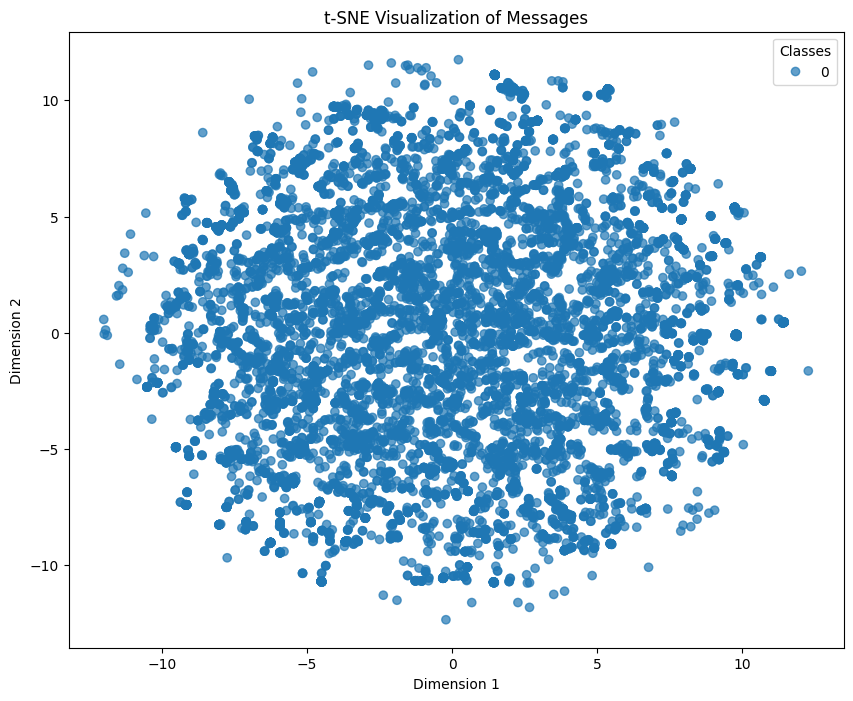

In [15]:
# Collect messages and labels from the test set
messages_list = []
labels_list = []
sender.eval()
with torch.no_grad():
    for images, _, labels in test_loader:
        images = images.to(device)
        messages = sender(images)
        messages = messages.view(images.size(0), -1)
        messages_list.append(messages.cpu().numpy())
        labels_list.append(labels.numpy())

# Prepare data for t-SNE
messages_array = np.concatenate(messages_list, axis=0)
labels_array = np.concatenate(labels_list, axis=0)

# Apply t-SNE
tsne = TSNE(n_components=2, perplexity=30, n_iter=300)
embeddings_2d = tsne.fit_transform(messages_array)

# Plot
plt.figure(figsize=(10, 8))
scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=labels_array, cmap='tab10', alpha=0.7)
plt.legend(*scatter.legend_elements(), title="Classes")
plt.title('t-SNE Visualization of Messages')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.show()


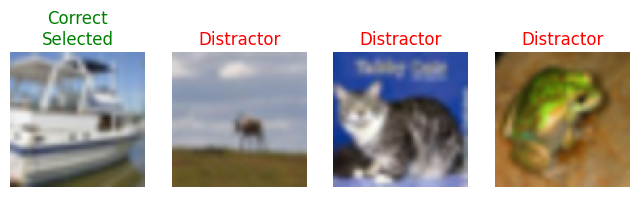

In [16]:
# Get a random sample from the test set
sender.eval()
receiver.eval()
idx = random.randint(0, len(test_dataset) - 1)
image, label = test_dataset[idx]
image = image.unsqueeze(0).to(device)

# Sender generates message
with torch.no_grad():
    message = sender(image)

# Prepare candidate images
distractors = random.sample(range(len(test_dataset)), num_distractors)
candidate_images = [test_dataset[idx][0]]
for d_idx in distractors:
    candidate_images.append(test_dataset[d_idx][0])
candidate_images = torch.stack(candidate_images).unsqueeze(0).to(device)

# Receiver makes a prediction
with torch.no_grad():
    probs = receiver(message, candidate_images)
    pred = torch.argmax(probs, dim=1).item()

# Display results
plt.figure(figsize=(8, 2))
for i in range(len(candidate_images[0])):
    plt.subplot(1, len(candidate_images[0]), i+1)
    img = candidate_images[0][i].cpu().permute(1, 2, 0).numpy()
    img = (img * 0.5) + 0.5  # Denormalize
    plt.imshow(img)
    plt.axis('off')
    if i == pred:
        plt.title('Selected' if i != 0 else 'Correct\nSelected', color='green')
    else:
        plt.title('Distractor', color='red')
plt.show()
